<a href="https://colab.research.google.com/github/Nicolenki7/German-Credit-Data---Feature-Importance/blob/main/German_Credit_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ----------------------------------------------------------------------
# 1. Importación de Librerías Esenciales
# ----------------------------------------------------------------------

import pandas as pd
import numpy as np

# Librerías para SQL (se usarán en la siguiente celda para Feature Engineering)
import sqlite3
from sqlite3 import connect

# Librerías para Modelado Predictivo (se usarán más adelante)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Librerías para Visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Configuraciones de visualización para un estilo profesional
sns.set_style("whitegrid")

# ----------------------------------------------------------------------
# 2. Carga del Dataset
# ----------------------------------------------------------------------

# Asegúrate de que el nombre del archivo coincida exactamente con el cargado en Colab
file_path = 'german_credit_cleaned.csv'
try:
    df = pd.read_csv(file_path)
    print(f"✅ Datos cargados correctamente. Filas: {df.shape[0]}, Columnas: {df.shape[1]}")
except FileNotFoundError:
    print(f"❌ Error: El archivo '{file_path}' no se encuentra. Revisa la ruta o el nombre.")
    df = pd.DataFrame() # Crear un DataFrame vacío para evitar errores posteriores

# ----------------------------------------------------------------------
# 3. Inspección Inicial de Datos
# ----------------------------------------------------------------------

print("\n--- Vista de las primeras 5 filas ---")
display(df.head())

print("\n--- Información de Tipos de Datos y Valores No Nulos ---")
df.info()

print("\n--- Distribución de la Variable Objetivo (Target) ---")
# 'target' es la variable que queremos predecir (Good Credit/Bad Credit)
display(df['target'].value_counts(normalize=True).mul(100).rename('Porcentaje (%)').to_frame())

✅ Datos cargados correctamente. Filas: 1000, Columnas: 21

--- Vista de las primeras 5 filas ---


,checking_acc_status,duration,cred_hist,purpose,loan_amt,saving_acc_bonds,present_employment_since,installment_rate,personal_stat_gender,other_debtors_guarantors,...,property,age,other_installment_plans,housing,num_curr_loans,job,num_people_provide_maint,telephone,is_foreign_worker,target
0,below_0,6,risky_acc_or_curr_loan_other,radio_tv,1169,unknown_no_saving_acc,above_7y,4,male:single,none,...,real_estate,67,none,own,2,skilled_official,1,yes,yes,good
1,below_200,48,curr_loans_paid_duly,radio_tv,5951,below_100,below_4y,2,female:divorced_or_married,none,...,real_estate,22,none,own,1,skilled_official,1,no,yes,bad
2,no_cheking_acc,12,risky_acc_or_curr_loan_other,education,2096,below_100,below_7y,2,male:single,none,...,real_estate,49,none,own,1,unskilled_resident,2,no,yes,good
3,below_0,42,curr_loans_paid_duly,furniture_equipment,7882,below_100,below_7y,2,male:single,guarantor,...,life_insurance_or_aggreements,45,none,for_free,1,skilled_official,2,no,yes,good
4,below_0,24,delay_in_past,car_new,4870,below_100,below_4y,3,male:single,none,...,unknown_or_no_property,53,none,for_free,2,skilled_official,2,no,yes,bad



--- Información de Tipos de Datos y Valores No Nulos ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   checking_acc_status       1000 non-null   object
 1   duration                  1000 non-null   int64 
 2   cred_hist                 1000 non-null   object
 3   purpose                   1000 non-null   object
 4   loan_amt                  1000 non-null   int64 
 5   saving_acc_bonds          1000 non-null   object
 6   present_employment_since  1000 non-null   object
 7   installment_rate          1000 non-null   int64 
 8   personal_stat_gender      1000 non-null   object
 9   other_debtors_guarantors  1000 non-null   object
 10  present_residence_since   1000 non-null   int64 
 11  property                  1000 non-null   object
 12  age                       1000 non-null   int64 
 13  other_installment_pla

,Porcentaje (%)
target,
good,70.0
bad,30.0


In [2]:
# ----------------------------------------------------------------------
# 1. Conexión a Base de Datos SQLite Temporal
# ----------------------------------------------------------------------

# Crear una conexión a una base de datos en memoria
conn = sqlite3.connect(':memory:')

# Cargar el DataFrame de Pandas a la tabla temporal 'credit_data'
df.to_sql('credit_data', conn, index=False, if_exists='replace')

print("✅ DataFrame cargado en la base de datos temporal SQLite.")

# ----------------------------------------------------------------------
# 2. Consulta SQL Estratégica para Feature Engineering
# ----------------------------------------------------------------------

sql_query = """
SELECT
    *,
    -- 1. FEATURE CLAVE: Ratio de Endeudamiento vs. Duración (para identificar préstamos agresivos)
    CAST(loan_amt AS REAL) / duration AS Debt_to_Duration_Ratio,

    -- 2. Categorización de la Edad para interpretación de riesgo (Joven, Adulto, Senior)
    CASE
        WHEN age < 25 THEN 'A. Joven (<25)'
        WHEN age >= 25 AND age < 45 THEN 'B. Adulto (25-44)'
        ELSE 'C. Senior (45+)'
    END AS age_risk_category,

    -- 3. Categorización de la Duración del Préstamo (para identificar riesgo a largo plazo)
    CASE
        WHEN duration <= 12 THEN 'Corto Plazo (<=12m)'
        WHEN duration > 12 AND duration <= 36 THEN 'Medio Plazo (13-36m)'
        ELSE 'Largo Plazo (>36m)'
    END AS duration_risk_category

FROM
    credit_data;
"""

# ----------------------------------------------------------------------
# 3. Ejecución de la Consulta y Creación del Nuevo DataFrame
# ----------------------------------------------------------------------

df_transformed = pd.read_sql_query(sql_query, conn)

print("✅ Consulta SQL ejecutada. Nuevas features creadas.")

# Cerrar la conexión
conn.close()

# ----------------------------------------------------------------------
# 4. Inspección del Nuevo DataFrame
# ----------------------------------------------------------------------

print("\n--- Vista de las nuevas columnas y primeras filas ---")
# Mostrar solo las columnas clave para verificar
display(df_transformed[['loan_amt', 'duration', 'Debt_to_Duration_Ratio', 'age_risk_category', 'duration_risk_category']].head())

print("\n--- Conteo de la nueva Categoría de Riesgo de Edad ---")
display(df_transformed['age_risk_category'].value_counts().to_frame())

✅ DataFrame cargado en la base de datos temporal SQLite.
✅ Consulta SQL ejecutada. Nuevas features creadas.

--- Vista de las nuevas columnas y primeras filas ---


,loan_amt,duration,Debt_to_Duration_Ratio,age_risk_category,duration_risk_category
0,1169,6,194.833333,C. Senior (45+),Corto Plazo (<=12m)
1,5951,48,123.979167,A. Joven (<25),Largo Plazo (>36m)
2,2096,12,174.666667,C. Senior (45+),Corto Plazo (<=12m)
3,7882,42,187.666667,C. Senior (45+),Largo Plazo (>36m)
4,4870,24,202.916667,C. Senior (45+),Medio Plazo (13-36m)



--- Conteo de la nueva Categoría de Riesgo de Edad ---


,count
age_risk_category,
B. Adulto (25-44),650
C. Senior (45+),201
A. Joven (<25),149


In [3]:
# ----------------------------------------------------------------------
# 1. Codificación de Variables Categóricas (One-Hot Encoding)
# ----------------------------------------------------------------------

# El modelo de Regresión Logística requiere variables numéricas.
# Usamos One-Hot Encoding en todas las columnas de tipo 'object' (categóricas),
# incluyendo las nuevas categorías creadas con SQL.

# 1.1 Identificar columnas categóricas (tipo 'object')
categorical_cols = df_transformed.select_dtypes(include=['object']).columns

# 1.2 Aplicar pd.get_dummies()
df_model = pd.get_dummies(df_transformed, columns=categorical_cols, drop_first=True)

# El argumento 'drop_first=True' se usa para evitar la multicolinealidad,
# eliminando una de las categorías para cada variable.

print("✅ Codificación One-Hot Encoding completada.")
print(f"Dimensiones del nuevo DataFrame para el modelo: {df_model.shape}")
# Las columnas deben aumentar significativamente después del encoding.

# ----------------------------------------------------------------------
# 2. Definición de Variables (X e y)
# ----------------------------------------------------------------------

# La variable objetivo 'target' se convirtió en 'target_good' y 'target_bad' durante el One-Hot.
# Seleccionamos 'target_good' como nuestra variable de interés (y = 1 si es buen crédito).

X = df_model.drop(columns=['target_good'])
y = df_model['target_good']

# ----------------------------------------------------------------------
# 3. División del Dataset (Entrenamiento y Prueba)
# ----------------------------------------------------------------------

# Dividir los datos: 70% para entrenamiento, 30% para prueba.
# Usamos stratify=y para asegurar que la proporción 70/30 (Good/Bad) se mantenga en ambos conjuntos.
# random_state=42 asegura que los resultados sean reproducibles.

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y # Importante por el desbalance 70/30
)

print("\n✅ Datos divididos en conjuntos de entrenamiento (70%) y prueba (30%).")
print(f"Dimensión de X_train: {X_train.shape}")
print(f"Dimensión de X_test: {X_test.shape}")
print(f"Proporción de 'Good Credit' en y_train: {y_train.mean():.2f}")

✅ Codificación One-Hot Encoding completada.
Dimensiones del nuevo DataFrame para el modelo: (1000, 54)

✅ Datos divididos en conjuntos de entrenamiento (70%) y prueba (30%).
Dimensión de X_train: (700, 53)
Dimensión de X_test: (300, 53)
Proporción de 'Good Credit' en y_train: 0.70


⚙️ Entrenando el modelo de Regresión Logística...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Entrenamiento completado.

--- 📊 Evaluación del Modelo ---
Matriz de Confusión:
 [[ 42  48]
 [ 33 177]]

Reporte de Clasificación:
              precision    recall  f1-score   support

  Bad Credit       0.56      0.47      0.51        90
 Good Credit       0.79      0.84      0.81       210

    accuracy                           0.73       300
   macro avg       0.67      0.65      0.66       300
weighted avg       0.72      0.73      0.72       300

AUC-ROC Score (Capacidad Predictiva): 0.7741


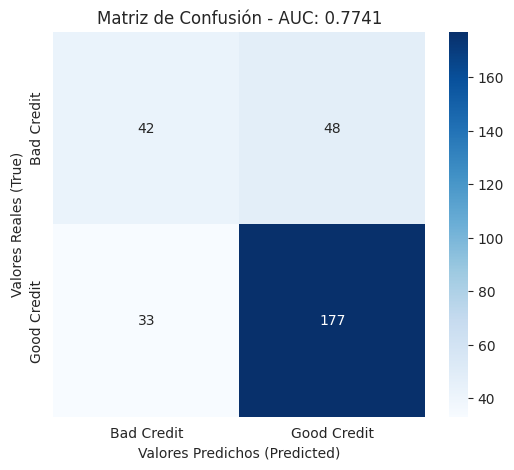

In [4]:
# ----------------------------------------------------------------------
# 1. Inicialización y Entrenamiento del Modelo
# ----------------------------------------------------------------------

# 1.1 Inicializar el modelo de Regresión Logística
# Usamos max_iter=1000 para asegurar la convergencia y random_state=42 para reproducibilidad.
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# 1.2 Entrenar el modelo con los datos de entrenamiento
print("⚙️ Entrenando el modelo de Regresión Logística...")
logreg_model.fit(X_train, y_train)
print("✅ Entrenamiento completado.")


# ----------------------------------------------------------------------
# 2. Predicciones y Probabilidades
# ----------------------------------------------------------------------

# Predicción de las etiquetas (0 o 1) en el conjunto de prueba
y_pred = logreg_model.predict(X_test)

# Predicción de las probabilidades (necesarias para la curva ROC y AUC)
y_pred_proba = logreg_model.predict_proba(X_test)[:, 1] # Probabilidad de ser 'Good Credit' (clase 1)


# ----------------------------------------------------------------------
# 3. Evaluación del Modelo y Métricas Clave
# ----------------------------------------------------------------------

print("\n--- 📊 Evaluación del Modelo ---")

# 3.1 Matriz de Confusión (para ver True Positives, False Positives, etc.)
conf_mat = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:\n", conf_mat)

# 3.2 Reporte de Clasificación (Precision, Recall, F1-Score)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['Bad Credit', 'Good Credit']))

# 3.3 AUC-ROC Score (Métrica principal para problemas de riesgo)
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score (Capacidad Predictiva): {auc_score:.4f}")


# ----------------------------------------------------------------------
# 4. Visualización de la Matriz de Confusión (Para el Portfolio)
# ----------------------------------------------------------------------

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad Credit', 'Good Credit'], yticklabels=['Bad Credit', 'Good Credit'])
plt.ylabel('Valores Reales (True)')
plt.xlabel('Valores Predichos (Predicted)')
plt.title(f'Matriz de Confusión - AUC: {auc_score:.4f}')
plt.show()

✅ Coeficientes de las variables extraídos y ordenados.


/tmp/ipython-input-2966801565.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_10_features, palette='viridis')


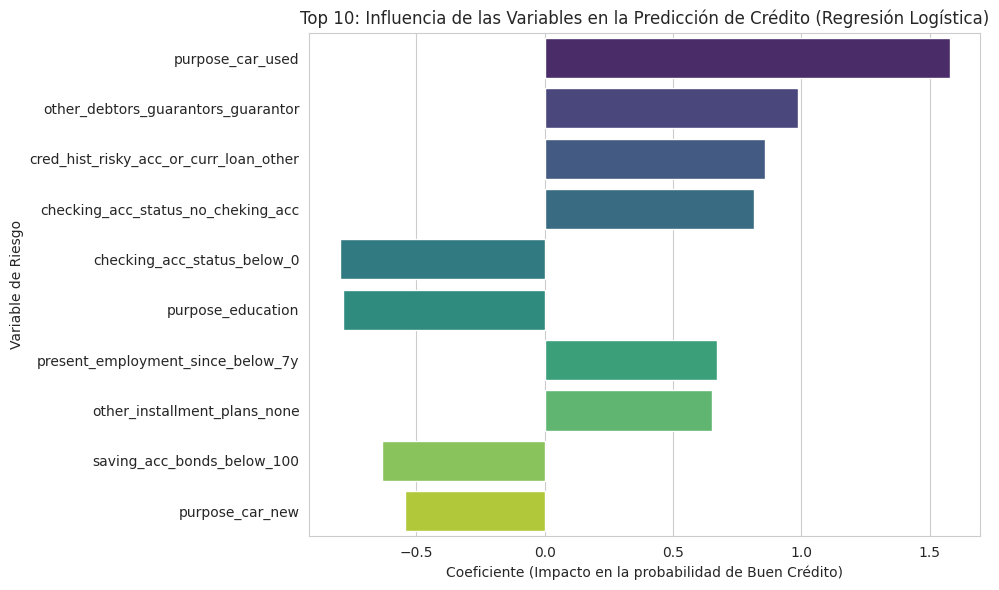


--- Top 5 Variables con MAYOR RIESGO (Coeficientes Negativos) ---


,Feature,Coefficient
8,checking_acc_status_below_0,-0.798973
18,purpose_education,-0.787347
24,saving_acc_bonds_below_100,-0.634547
15,purpose_car_new,-0.545781
39,property_unknown_or_no_property,-0.450207


In [5]:
# ----------------------------------------------------------------------
# 1. Extracción de Coeficientes del Modelo
# ----------------------------------------------------------------------

# La importancia de una variable en Regresión Logística viene dada por su coeficiente.
coefficients = logreg_model.coef_[0]
feature_names = X_train.columns

# Crear un DataFrame para facilitar la visualización
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Calcular el valor absoluto para ordenar por magnitud de influencia
feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient'].abs()

# Ordenar por magnitud de influencia y tomar las Top 10
top_10_features = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False).head(10)

print("✅ Coeficientes de las variables extraídos y ordenados.")

# ----------------------------------------------------------------------
# 2. Visualización de las TOP 10 Features
# ----------------------------------------------------------------------

plt.figure(figsize=(10, 6))
# Gráfico de barras para las TOP 10 Features (ordenado por influencia)
sns.barplot(x='Coefficient', y='Feature', data=top_10_features, palette='viridis')
plt.title('Top 10: Influencia de las Variables en la Predicción de Crédito (Regresión Logística)')
plt.xlabel('Coeficiente (Impacto en la probabilidad de Buen Crédito)')
plt.ylabel('Variable de Riesgo')
plt.tight_layout()
plt.show()


# ----------------------------------------------------------------------
# 3. Interpretación de las Features Más Negativas (Riesgo)
# ----------------------------------------------------------------------

# Mostrar las 5 variables con el coeficiente más bajo (mayor riesgo de Mal Crédito)
top_5_negative = feature_importance.sort_values(by='Coefficient', ascending=True).head(5)
print("\n--- Top 5 Variables con MAYOR RIESGO (Coeficientes Negativos) ---")
display(top_5_negative[['Feature', 'Coefficient']])